# Práctica 3: Visualización de Mapas y Datos Espaciales (notebook preliminario)

Por Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

#### Objetivo

En este notebook trabajaremos con información geográfica. Este notebook genera información preliminar para la clase de mapas. Vamos a cargar y procesar datos geográficos en formato shapefile, con la biblioteca `geopandas`. Esto incluye cruzar y operar con archivos desde distintas fuentes y en distintos sistemas de coordenadas.

### Preámbulo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# incorporamos geopandas! geografía + pandas :)
import geopandas as gpd

from aves.data import eod

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Code', style='ticks', palette='colorblind', font_scale=1.1)

In [3]:
viajes = eod.read_trips()
viajes.columns

Index(['Hogar', 'Persona', 'Viaje', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada'],
      dtype='object')

In [4]:
viajes.head()

,Hogar,Persona,Viaje,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada
0,173431,17343102,1734310202,1,Maipú,Maipú,Poniente,Poniente,400,407,...,1.000000,NaN,NaN,NaN,NaN,0.0,Bip!,5387,7608,0
1,173441,17344101,1734410101,2,Maipú,Las Condes,Poniente,Oriente,407,307,...,1.127220,NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0
2,173441,17344101,1734410102,2,Las Condes,Maipú,Oriente,Poniente,307,407,...,1.127220,NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0
3,173441,17344103,1734410301,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,...,1.127220,NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0
4,173441,17344103,1734410302,2,Ñuñoa,Maipú,Oriente,Poniente,437,407,...,1.052764,NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0


In [5]:
# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[(viajes['SectorOrigen'] != 'Exterior a RM') 
                & (viajes['SectorDestino'] != 'Exterior a RM')
                & (viajes['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes['SectorOrigen'])
                & pd.notnull(viajes['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes['DistManhattan'].between(500, 35000))]

print(len(viajes))

77288


### Geografía

Para datos geográficos trabajaremos con el formato `shapefile`. Se define así:

> El formato ESRI Shapefile (SHP) es un formato de archivo informático propietario de datos espaciales desarrollado por la compañía ESRI, quien crea y comercializa software para Sistemas de Información Geográfica como Arc/Info o ArcGIS. Originalmente se creó para la utilización con su producto ArcView GIS, pero actualmente se ha convertido en formato estándar de facto para el intercambio de información geográfica entre Sistemas de Información Geográfica por la importancia que los productos ESRI tienen en el mercado SIG y por estar muy bien documentado.
>
> Un shapefile es un formato vectorial de almacenamiento digital donde se guarda la localización de los elementos geográficos y los atributos asociados a ellos. No obstante carece de capacidad para almacenar información topológica. Es un formato multiarchivo, es decir está generado por varios ficheros informáticos. 
>
> -- [Wikipedia](https://es.wikipedia.org/wiki/Shapefile)

En general, los archivos `.shp` se almacenan en una carpeta donde otros archivos complementarios a la geografía tienen el mismo nombre pero con extensiones diferentes, por ejemplo, para almacenar meta-datos de la geografía.

#### Shapefile de la Encuesta Origen-Destino

La encuesta origen-destino disponibiliza un `shapefile` de las zonas de estudio en la [biblioteca](http://www.sectra.gob.cl/encuestas_movilidad/encuestas_movilidad.htm) de la SECTRA (Secretaría de Transporte). Sin embargo, el link está escondido en el código fuente de la página, ya que presenta problemas de rendering. Afortunadamente ya está en el repositorio del curso :)

Para cargar `shapefiles` podemos usar la función `read_file` de `geopandas`, entregando la carpeta donde esté nuestro archivo `.shp`. Si solamente hay un `.shp`, la biblioteca lo detecta automáticamente:

In [6]:
zonas_eod = eod.read_zone_design()
zonas_eod.head()

,ID,AREA,Zona,Com,Comuna,geometry
0,103,837.7500,103.0,13105,El Bosque,"POLYGON ((346376.693 6286027.029, 346366.556 6..."
1,104,998.8125,104.0,13105,El Bosque,"POLYGON ((344151.235 6285465.040, 344263.705 6..."
2,106,286.2500,106.0,13105,El Bosque,"POLYGON ((344415.434 6285878.048, 344263.705 6..."
3,115,857.4375,115.0,13105,El Bosque,"POLYGON ((344415.434 6285878.048, 344412.704 6..."
4,116,853.9375,116.0,13105,El Bosque,"POLYGON ((345133.421 6286261.983, 345243.965 6..."


Como ven, su apariencia es la de un `DataFrame`. Sin embargo, la columna `geometry` tiene un significado especial: contiene los elementos geográficos.

Adicionalmente, un `GeoDataFrame` tiene un método `plot` que se encarga de graficar los contenidos geográficos:

In [7]:
type(zonas_eod)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

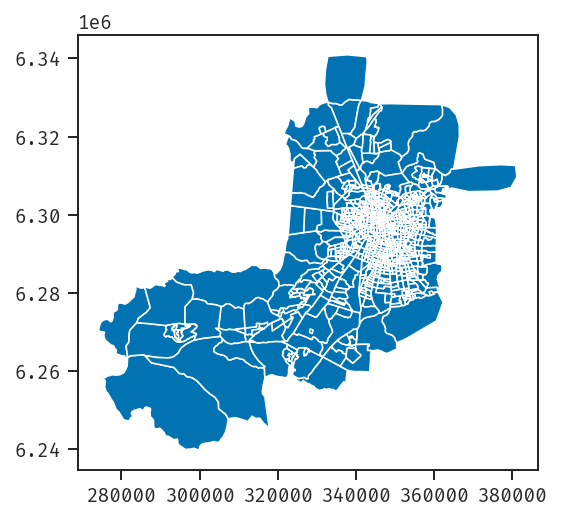

In [8]:
zonas_eod.plot()

El sistema de coordenadas utilizado por este fichero se puede ver con el atributo `crs` del `GeoDataFrame`:

In [9]:
zonas_eod.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - S hemisphere - 72°W to 66°W - by country
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Aquí está la especificación del sistema de coordenadas [`EPSG:32719`](https://epsg.io/32719). Más adelante veremos que los archivos pueden tener sistemas de coordenadas distintos, pero que `geopandas` nos ayuda a trabajar con ello.

Un `GeoDataFrame` puede hacer las mismas operaciones que un `DataFrame` tradicional, incluyendo filtrado utilizando el operador `[]`. Aquí graficaremos las zonas para las cuales tenemos viajes en nuestra tabla de viajes. Noten que la columna `ID` del `GeoDataFrame` tiene (por definición) la misma codificación que las columnas `ZonaOrigen` y `ZonaDestino` de la tabla de viajes:

<AxesSubplot:>

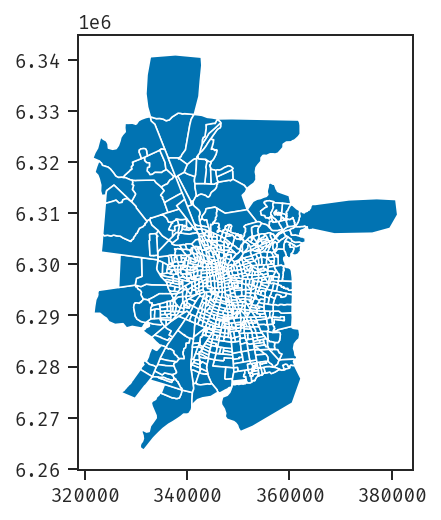

In [10]:
zonas_con_viajes = zonas_eod[zonas_eod.ID.isin(viajes.ZonaOrigen.unique())
                           & zonas_eod.ID.isin(viajes.ZonaDestino.unique())]
zonas_con_viajes.plot()

Tenemos menos zonas. Sin embargo, queda la sensación de que tenemos muchas zonas grandes correspondientes a zonas rurales que ocupan más espacio en el mapa que las zonas urbanas. Podemos mejorar esto utilizando datos del Censo 2017.

#### Shapefiles del Censo

El Censo 2017 disponibiliza una serie de `shapefiles` para cada región del país. En este caso, cargaremos un mapa para la Región Metropolitana (en la carpeta `R13`) con los límites urbanos definidos por el INE. Noten que en este caso le indicamos el nombre del archivo `.shp` a `geopandas`, debido a que la carpeta tiene otros ficheros `.shp`.

In [11]:
from aves.data import census

In [12]:
rm = census.read_census_map('limite_urbano_censal')

In [13]:
rm.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,CAPITAL COMUNAL,CIUDAD,0.146714,0.000531,"POLYGON ((-70.73797 -33.79851, -70.73738 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HUELQUÉN,URBANO,PUEBLO,0.167916,0.000205,"POLYGON ((-70.64840 -33.81521, -70.64859 -33.8..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HOSPITAL,URBANO,CIUDAD,0.139694,0.000445,"POLYGON ((-70.76468 -33.84349, -70.76448 -33.8..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PINTUÉ - LA GUACHERA,URBANO,PUEBLO,0.148207,0.000292,"POLYGON ((-70.87824 -33.86540, -70.87839 -33.8..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,EL TRÁNSITO,URBANO,PUEBLO,0.073625,0.000066,"POLYGON ((-70.65834 -33.78357, -70.65832 -33.7..."


<AxesSubplot:>

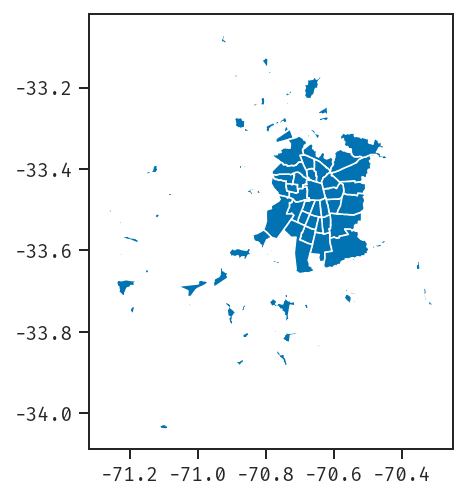

In [14]:
rm.plot()

Notamos que tiene una área geográfica por comuna. Sabemos que en Santiago hay tres provincias que nos interesan, así que nos gustaría tener un área por provincia (que podría tener varios polígonos, no necesariamente uno). Para ello podemos usar el método `dissolve` de `geopandas` de la siguiente manera:

<AxesSubplot:>

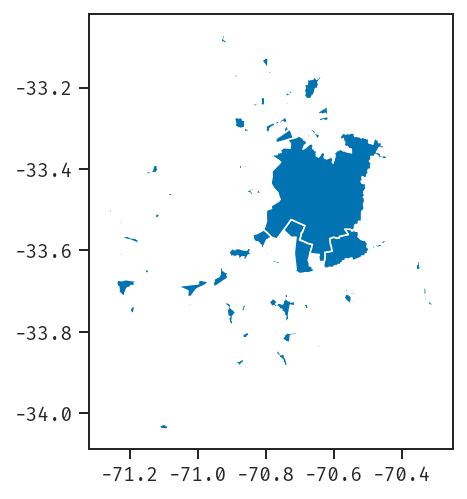

In [15]:
provincias = rm.dissolve(by='NOM_PROVIN')
provincias.plot()

In [16]:
provincias.head()

,geometry,REGION,NOM_REGION,PROVINCIA,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area
NOM_PROVIN,,,,,,,,,,,
CHACABUCO,"MULTIPOLYGON (((-70.74272 -33.27155, -70.74256...",13,REGIÓN METROPOLITANA DE SANTIAGO,133,13301,COLINA,COLINA,CAPITAL PROVINCIAL,CIUDAD,0.302769,0.001673
CORDILLERA,"MULTIPOLYGON (((-70.56310 -33.69543, -70.56212...",13,REGIÓN METROPOLITANA DE SANTIAGO,132,13201,PUENTE ALTO,PUENTE ALTO,CAPITAL PROVINCIAL,CIUDAD,0.477213,0.007370
MAIPO,"MULTIPOLYGON (((-70.66200 -33.89438, -70.66198...",13,REGIÓN METROPOLITANA DE SANTIAGO,134,13404,PAINE,PAINE,CAPITAL COMUNAL,CIUDAD,0.146714,0.000531
MELIPILLA,"MULTIPOLYGON (((-71.09826 -34.02744, -71.09753...",13,REGIÓN METROPOLITANA DE SANTIAGO,135,13504,MARÍA PINTO,MARÍA PINTO,CAPITAL COMUNAL,PUEBLO,0.046109,0.000112
SANTIAGO,"MULTIPOLYGON (((-70.51814 -33.50389, -70.51815...",13,REGIÓN METROPOLITANA DE SANTIAGO,131,13124,PUDAHUEL,LO AGUIRRE,URBANO,PUEBLO,0.048678,0.000102


Como ven, desaparecieron los bordes comunales, y la columna `NOM_PROVIN` define un índice en la tabla. Esto se debe a que el resultado es equivalente a hacer un `groupby` en `pandas`. Con el operador `.loc[]` de `pandas` (y por ende, `geopandas`) podemos elegir las filas del índice que nos interesan: 

<AxesSubplot:>

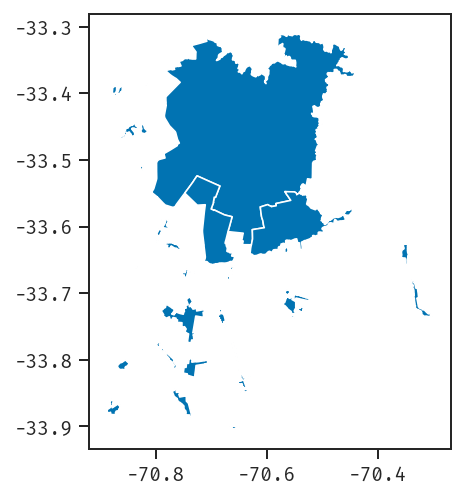

In [17]:
provincias = provincias.loc[['SANTIAGO', 'CORDILLERA', 'MAIPO']]
provincias.plot()

¡Mucho mejor! El siguiente paso es ver como podemos intersectar las zonas EOD que tenemos con estas áreas urbanas, de modo que las zonas que estén en los bordes urbanos se recorten y queden solamente con la sección urbana que les corresponda.

Para ello podemos usar la operación `overlay` de `geopandas`. Este método recibe dos `GeoDataFrame` y un nombre de operación. En este caso, diremos que queremos _intersectar_ con `zonas_con_viajes` y `rm`:

<ipython-input-18-15add3e2327d>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32719
Right CRS: GEOGCS["GCS_SIRGAS_2000",DATUM["D_SIRGAS_2000",SPH ...

  zonas_urbanas = gpd.overlay(zonas_con_viajes, rm, how='intersection')
/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

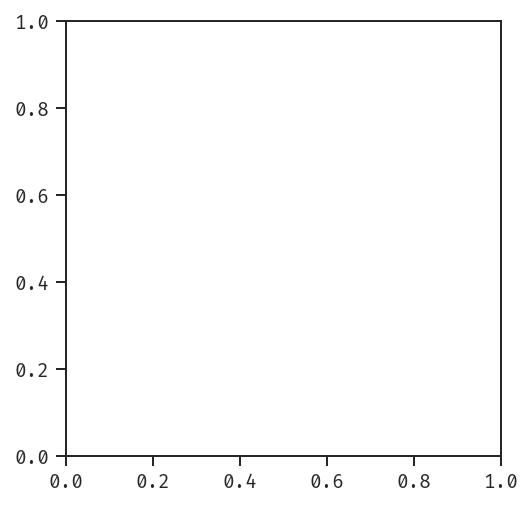

In [18]:
zonas_urbanas = gpd.overlay(zonas_con_viajes, rm, how='intersection')
zonas_urbanas.plot()

¡No pasó nada! 

Omitimos un paso crucial a la hora de trabajar con distintos `GeoDataFrames`: verificar que tengan el mismo sistema de coordenadas.

In [19]:
rm.crs, zonas_con_viajes.crs

(<Geographic 2D CRS: GEOGCS["GCS_SIRGAS_2000",DATUM["D_SIRGAS_2000",SPH ...>
 Name: SIRGAS 2000
 Axis Info [ellipsoidal]:
 - lon[east]: Longitude (Degree)
 - lat[north]: Latitude (Degree)
 Area of Use:
 - undefined
 Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich,
 <Projected CRS: EPSG:32719>
 Name: WGS 84 / UTM zone 19S
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - S hemisphere - 72°W to 66°W - by country
 - bounds: (-72.0, -80.0, -66.0, 0.0)
 Coordinate Operation:
 - name: UTM zone 19S
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

No eran el mismo. Podemos usar el método `to_crs` de `geopandas` para cambiar el sistema de coordenadas de un `geodataframe`:

<AxesSubplot:>

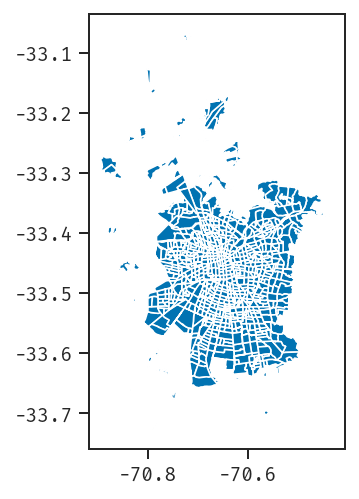

In [20]:
zonas_urbanas = gpd.overlay(zonas_con_viajes.to_crs(rm.crs), rm, how='intersection')
zonas_urbanas.plot()

¡Ahora sí! Tenemos las mismas zonas EOD de antes, pero en el sistema de coordenadas de `rm`, y considerando solamente las áreas urbanas definidas en el censo. 

Todavía nos falta quitar algunas zonas. Lo podemos hacer manualmente:


In [21]:
zonas_urbanas.Comuna.value_counts()

Santiago               86
La Florida             63
Puente Alto            56
Las Condes             56
Maipú                  54
Ñuñoa                  43
Pudahuel               42
Peñalolén              42
La Reina               38
Recoleta               38
Estación Central       38
Providencia            38
San Bernardo           37
Quinta Normal          35
San Joaquín            34
Pedro Aguirre Cerda    34
San Ramón              33
Colina                 32
La Pintana             29
Vitacura               29
La Granja              29
Renca                  29
La Cisterna            28
Cerrillos              28
Conchalí               28
Cerro Navia            28
Macul                  26
Huechuraba             24
Lo Prado               24
Quilicura              23
El Bosque              23
San Miguel             22
Lo Espejo              21
Lampa                  19
Independencia          18
Lo Barnechea           18
Calera de Tango        12
Pirque                  3
Name: Comuna

Saquemos a comunas que estén fuera del área urbana principal de Santiago: Pirque, Calera de Tango, Lampa, Colina.

In [22]:
zonas_urbanas = zonas_urbanas[~zonas_urbanas.Comuna.isin(['Pirque', 'Calera de Tango', 'Lampa', 'Colina'])]


Así quedó el `GeoDataFrame` final:

<AxesSubplot:>

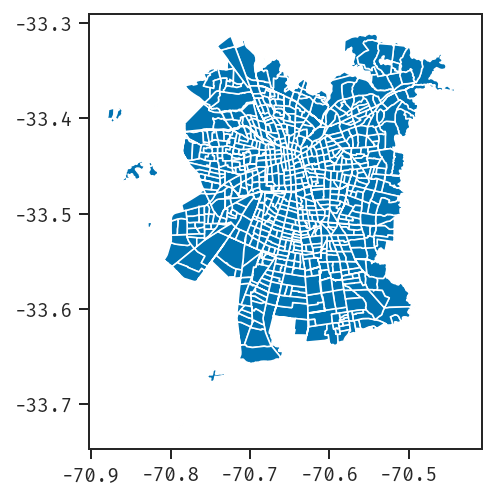

In [23]:
zonas_urbanas.plot()

In [24]:
zonas_urbanas.head()

,ID,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry
0,103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((-70.65485 -33.55436, -70.65497 -33.5..."
1,104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((-70.67891 -33.55911, -70.67767 -33.5..."
2,106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((-70.67599 -33.55542, -70.67767 -33.5..."
3,115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((-70.67599 -33.55542, -70.67602 -33.5..."
4,116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((-70.66819 -33.55207, -70.66701 -33.5..."


El siguiente paso es cambiarle el índice, eligiendo el atributo `ID` para ese fin. Esto nos permitirá cruzarlo con la tabla de viajes si es necesario.

In [25]:
zonas_urbanas = zonas_urbanas.set_index('ID')

En este punto, ya tenemos dos elementos que podemos utilizar para trabajar con viajes en el área urbana de Santiago.

In [26]:
from aves.data import DATA_PATH
zonas_urbanas.to_file(DATA_PATH / 'processed/scl_zonas_urbanas.json', driver='GeoJSON')

#### Otra Alternativa cuando no tenemos un marco de referencia

A veces solo sabemos que queremos visualizar un área, pero no tenemos sus bordes ni un shapefile que defina lo que usamos como "área urbana".

En tal caso, uno puede acudir a servicios como [bbox finder](http://bboxfinder.com/#-33.675211,-70.946274,-33.230647,-70.456009) donde se puede dibujar un área de interés. 

In [29]:
bbox_bounds = [-70.946274, -33.675211, -70.456009, -33.230647]

In [44]:
from aves.features.geo import clip_area_geodataframe

<AxesSubplot:>

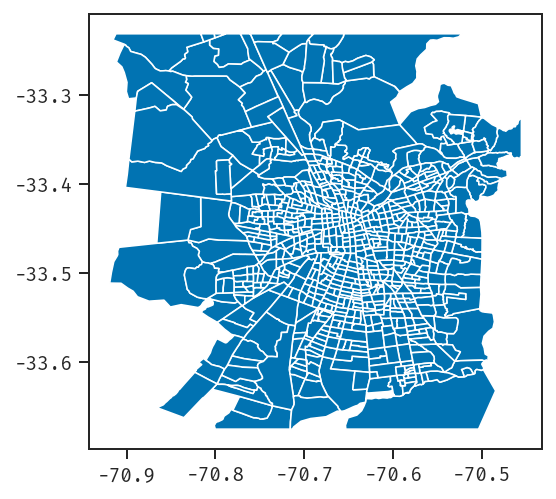

In [45]:
zonas_en_caja = clip_area_geodataframe(zonas_con_viajes.to_crs('epsg:4326'), bbox_bounds)
zonas_en_caja.plot()

Puede ser útil en sus proyectos :)